In [77]:
pip install plydata


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import pandas as pd
import numpy as np
import joblib
import plydata.cat_tools as cat
import plotnine as pn
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

In [79]:
pn.options.dpi=300

Data Preparation


In [80]:
url1='https://raw.githubusercontent.com/ServeshKhandwe/Myfile/main/customer.csv?token=GHSAT0AAAAAABXQXSWMMTUKEOFWK7YF4SVKYXZHSQQ'
customers=pd.read_csv(url1)

In [81]:
transactions=pd.read_csv('https://raw.githubusercontent.com/ServeshKhandwe/Myfile/main/Transactions.csv?token=GHSAT0AAAAAABXQXSWNSF7BHECIVOLWR4PGYXZHSSA')

In [82]:
time=pd.read_csv('https://raw.githubusercontent.com/ServeshKhandwe/Myfile/main/time.csv?token=GHSAT0AAAAAABXQXSWNWUSHNYBRS4SEORX6YXZHSPA')

In [83]:
data=pd.merge(customers,transactions,on ='customer_id', how ='inner')

In [84]:
data2=pd.merge(data,time, on='time_id', how="inner")

In [85]:
fdata=data2[['customer_id', 'the_date', 'unit_sales', 'store_sales']]

In [86]:
fdata

,customer_id,the_date,unit_sales,store_sales
0,3,1997-04-27 00:00:00,3.0,2.79
1,3,1997-04-27 00:00:00,2.0,5.56
2,3,1997-04-27 00:00:00,2.0,2.76
3,3,1997-04-27 00:00:00,2.0,4.46
4,3,1997-04-27 00:00:00,3.0,6.84
...,...,...,...,...
251390,7557,1997-04-25 00:00:00,1.0,1.86
251391,7889,1997-04-25 00:00:00,1.0,1.85
251392,7889,1997-04-25 00:00:00,2.0,5.66
251393,7889,1997-04-25 00:00:00,1.0,1.90


In [87]:
fdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251395 entries, 0 to 251394
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   customer_id  251395 non-null  int64  
 1   the_date     251395 non-null  object 
 2   unit_sales   251395 non-null  float64
 3   store_sales  251395 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 9.6+ MB


In [88]:
fdata['the_date']=fdata['the_date'].map(lambda x:x.rstrip('00:00:00'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [89]:
fdata['the_date']

0         1997-04-27 
1         1997-04-27 
2         1997-04-27 
3         1997-04-27 
4         1997-04-27 
             ...     
251390    1997-04-25 
251391    1997-04-25 
251392    1997-04-25 
251393    1997-04-25 
251394    1997-04-25 
Name: the_date, Length: 251395, dtype: object

In [90]:
fdata['the_date']=pd.to_datetime(fdata['the_date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Cohort Analysis

getting a range of intial purchases


In [91]:
initial_purchases=fdata\
  .sort_values(['customer_id', 'the_date'])\
  .groupby('customer_id')\
  .first()

In [92]:
initial_purchases

,the_date,unit_sales,store_sales
customer_id,,,
3,1997-04-27,3.0,2.79
5,1997-01-04,2.0,1.08
6,1997-07-23,4.0,13.32
8,1998-03-02,2.0,6.92
9,1998-04-27,3.0,4.80
...,...,...,...
10275,1997-05-05,4.0,15.72
10277,1997-04-01,4.0,5.28
10278,1998-02-27,2.0,1.80


In [93]:
initial_purchases['the_date'].min()

Timestamp('1997-01-01 00:00:00')

In [94]:
initial_purchases['the_date'].max()

Timestamp('1998-11-28 00:00:00')

In [95]:
d=fdata

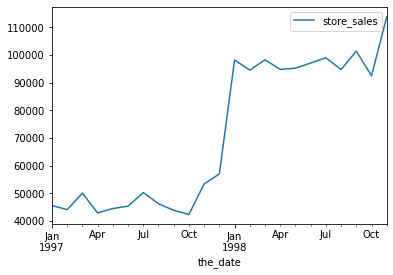

In [96]:
d\
  .reset_index()\
  .set_index('the_date')\
  [['store_sales']]\
  .resample(
      rule="MS"
  )\
  .sum()\
  .plot()

In the above graph you can see the purchasing behaviour of our local store. 

In [97]:
ids=d['customer_id'].unique()

In [98]:
ids.size

8736

In [99]:
ids_select=ids[0:10]

In [100]:
ids_select.size

10

In [101]:
nd=fdata\
  [fdata['customer_id'].isin(ids_select)]\
  .groupby(['customer_id','the_date'])\
  .sum()\
  .reset_index()

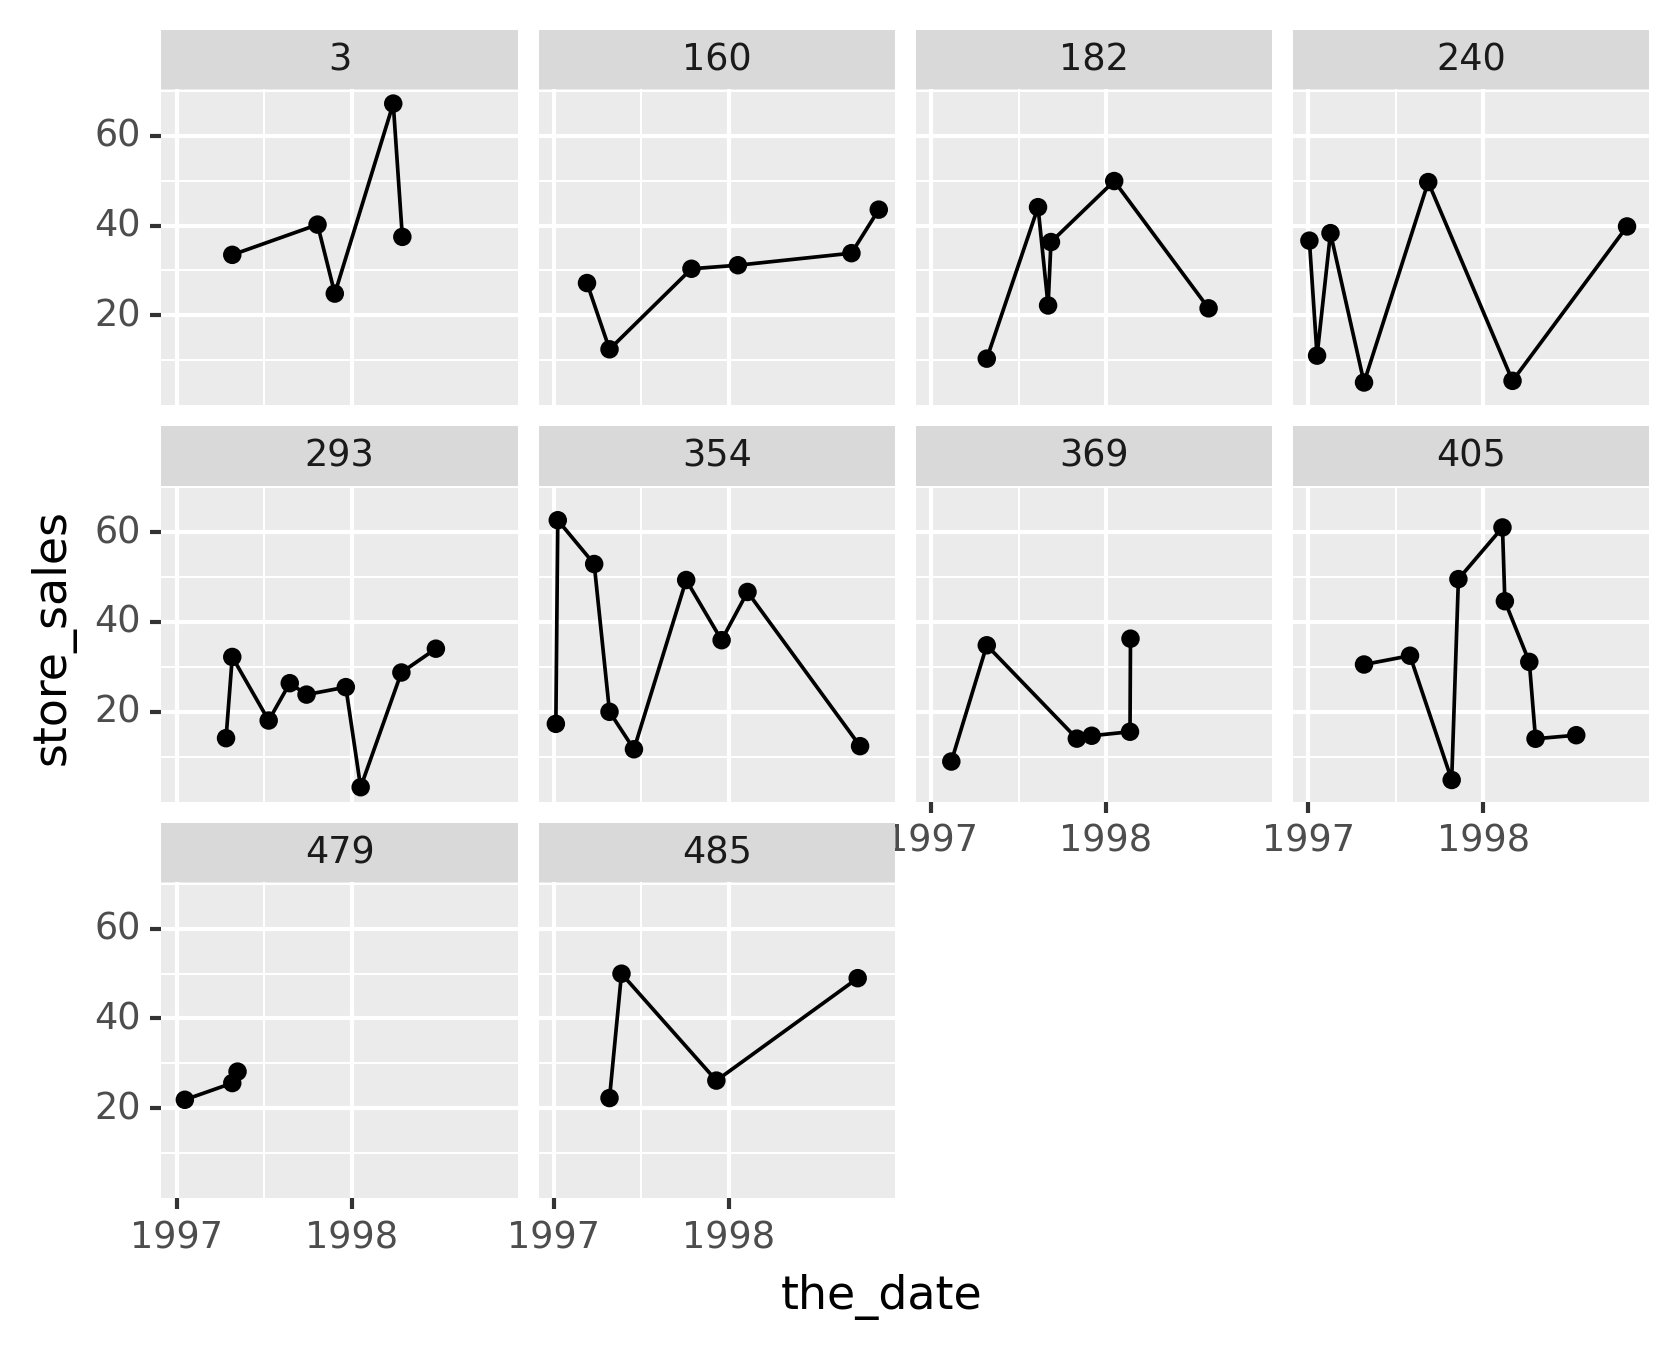

<ggplot: (8759973218665)>

In [102]:
from pandas.core import groupby
pn.ggplot(
    pn.aes('the_date','store_sales', group='customer_id'),
    data=nd
)\
    +pn.geom_line()\
    +pn.geom_point()\
    +pn.facet_wrap('customer_id')\
    +pn.scale_x_date(
        date_breaks="1 year",
        date_labels="%Y"
    )

Machine Learnings


Time-Spliting

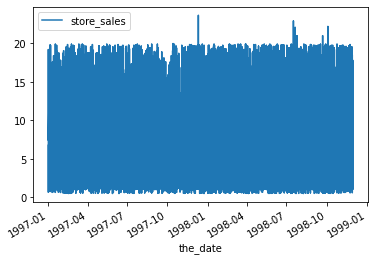

In [103]:
fdata.plot(x='the_date',  y='store_sales')

In [104]:
n_days=90
max_date=fdata['the_date'].max()
cutoff=max_date-pd.to_timedelta(n_days,unit="d")

In [105]:
#training dataset
temp_indata=fdata\
  [fdata['the_date']<=cutoff]

#testing dataset
temp_outdata=fdata\
  [fdata['the_date']>cutoff]


Now we do RFM (Feature Engineering)


Make Targets from out data

In [106]:
target=temp_outdata\
  .drop('unit_sales', axis=1)\
  .groupby('customer_id')\
  .sum()\
  .rename({'store_sales': 'spend_90_total'}, axis=1)\
  .assign(spend_90_flag=1)

In [107]:
target


,spend_90_total,spend_90_flag
customer_id,,
8,146.54,1
9,49.41,1
20,133.14,1
21,25.50,1
24,45.09,1
...,...,...
10263,74.42,1
10271,120.61,1
10273,70.35,1


from the above table we can see that in the specified period only 4825 customers have spend 

Make Recency (Date) Features from in data

In [108]:
max_date=temp_indata['the_date'].max()
recency_feature=temp_indata\
  [['customer_id','the_date']]\
  .groupby('customer_id')\
  .apply(
      lambda x: (x['the_date'].max()-max_date)/ pd.to_timedelta(1,"day")
  )\
  .to_frame()\
  .set_axis(["recency"], axis=1)

recency_feature

  
#tells how recent there purchases were, for example customer-id=3 has done its last purchase 137 days back from the max date 



,recency
customer_id,
3,-137.0
5,-605.0
6,-68.0
8,-46.0
9,-127.0
...,...
10275,-58.0
10277,-159.0
10278,-126.0


Make frequency (Count) Features from in data

In [109]:
frequency_feature=temp_indata\
  [['customer_id', 'the_date']]\
  .groupby('customer_id')\
  .count()\
  .set_axis(['frequency'], axis=1)

frequency_feature


,frequency
customer_id,
3,30
5,1
6,12
8,19
9,7
...,...
10275,22
10277,9
10278,28


Make Price (Monetary) Features from in data

In [110]:
price_feature=temp_indata\
  .groupby('customer_id')\
  .aggregate(
      {
          'store_sales': ["sum", "mean"]
      }
  )\
  .set_axis(['sales_sum','sales_mean'], axis=1)

price_feature

,sales_sum,sales_mean
customer_id,,
3,203.17,6.772333
5,1.08,1.080000
6,112.74,9.395000
8,112.60,5.926316
9,40.17,5.738571
...,...,...
10275,157.30,7.150000
10277,89.86,9.984444
10278,167.24,5.972857


Combine above features

In [111]:
features=pd.concat(
    [recency_feature,frequency_feature,price_feature], axis=1
)\
  .merge(
      target,
      left_index=True,
      right_index=True,
      how="left"
  )\
  .fillna(0)
features

,recency,frequency,sales_sum,sales_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
3,-137.0,30,203.17,6.772333,0.00,0.0
5,-605.0,1,1.08,1.080000,0.00,0.0
6,-68.0,12,112.74,9.395000,0.00,0.0
8,-46.0,19,112.60,5.926316,146.54,1.0
9,-127.0,7,40.17,5.738571,49.41,1.0
...,...,...,...,...,...,...
10275,-58.0,22,157.30,7.150000,0.00,0.0
10277,-159.0,9,89.86,9.984444,140.48,1.0
10278,-126.0,28,167.24,5.972857,0.00,0.0


Machine Learning


In [112]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV

Model1: Predict how much customer will spend in next 90 days-------
- the following are our regressors

In [113]:
X=features[['recency','frequency', 'sales_sum', 'sales_mean']]

ML1= Next 90 day prediction

In [114]:
y_spend=features['spend_90_total']
y_spend


customer_id
3          0.00
5          0.00
6          0.00
8        146.54
9         49.41
          ...  
10275      0.00
10277    140.48
10278      0.00
10280     59.45
10281      0.00
Name: spend_90_total, Length: 8426, dtype: float64

In [115]:
y_spend=features['spend_90_total']

xgb_reg_spec=XGBRegressor(
    objective="reg:squarederror",
    random_state=123
)



In [116]:
xgb_reg_model=GridSearchCV(
    estimator=xgb_reg_spec,
    param_grid=dict(
        learning_rate=[0.01,0.1,0.3,0.5]
    ),
    scoring='neg_mean_absolute_error',
    refit=True,
    cv=5
)

In [117]:
xgb_reg_model.fit(X,y_spend)

GridSearchCV(cv=5,
             estimator=XGBRegressor(objective='reg:squarederror',
                                    random_state=123),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='neg_mean_absolute_error')

In [118]:
xgb_reg_model.best_score_

-28.642946346349866

The above evaluation means that we are on average off by 28 euros per customer(It should be as low as possible) but it isn't bad consedering we are getting 100s of euros (as we can see from y_spend)

In [119]:
xgb_reg_model.best_params_
xgb_reg_model.best_estimator_


XGBRegressor(learning_rate=0.01, objective='reg:squarederror', random_state=123)

In [120]:
predictions_reg=xgb_reg_model.predict(X)
predictions_reg

array([18.977303 ,  5.0027194, 12.996088 , ..., 18.876333 , 23.329084 ,
       24.970182 ], dtype=float32)

it means that the first customer on the list will spend 18 euros 

ML2= Next 90 day probability, here instead of predicting the amount spend we would rather see if they are gonna spend or not

In [121]:
y_prob=features['spend_90_flag']

In [122]:
xgb_clf_spec=XGBClassifier(
    objective="binary:logistic",
    random_state=123
)

In [123]:
xgb_clf_model=GridSearchCV(
    estimator=xgb_clf_spec,
    param_grid=dict(
        learning_rate=[0.01,0.1,0.3,0.5]
    ),
    scoring='roc_auc',
    refit=True,
    cv=5
)

In [124]:
xgb_clf_model.fit(X,y_prob)

GridSearchCV(cv=5, estimator=XGBClassifier(random_state=123),
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5]},
             scoring='roc_auc')

In [125]:
xgb_clf_model.best_score_

0.71725302166265

Which is nice concedering that 1.0 is the perfect model, it is much further away from random guessing

In [126]:
xgb_clf_model.best_params_
xgb_clf_model.best_estimator_

XGBClassifier(learning_rate=0.01, random_state=123)

In [127]:
predictions_clf=xgb_clf_model.predict_proba(X)
predictions_clf


array([[0.46366125, 0.53633875],
       [0.72216904, 0.277831  ],
       [0.5041783 , 0.49582174],
       ...,
       [0.4662925 , 0.5337075 ],
       [0.40924007, 0.59075993],
       [0.4069262 , 0.5930738 ]], dtype=float32)

What we can infer from the array is that the probability of repurchase from the respective customers for example 1st customer_id has 46% chance of repurchase.

-------------------
Feature Importance (Global)

In [128]:
imp_spend_amount_dict=xgb_reg_model\
  .best_estimator_\
  .get_booster()\
  .get_score(importance_type='gain')

In [129]:
imp_spend_amount_df=pd.DataFrame(
    data={
        'feature':list(imp_spend_amount_dict.keys()),
        'value':list(imp_spend_amount_dict.values())
    }
)\
  .assign(
      feature=lambda x:cat.cat_reorder(x['feature'], x['value'])
  )

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


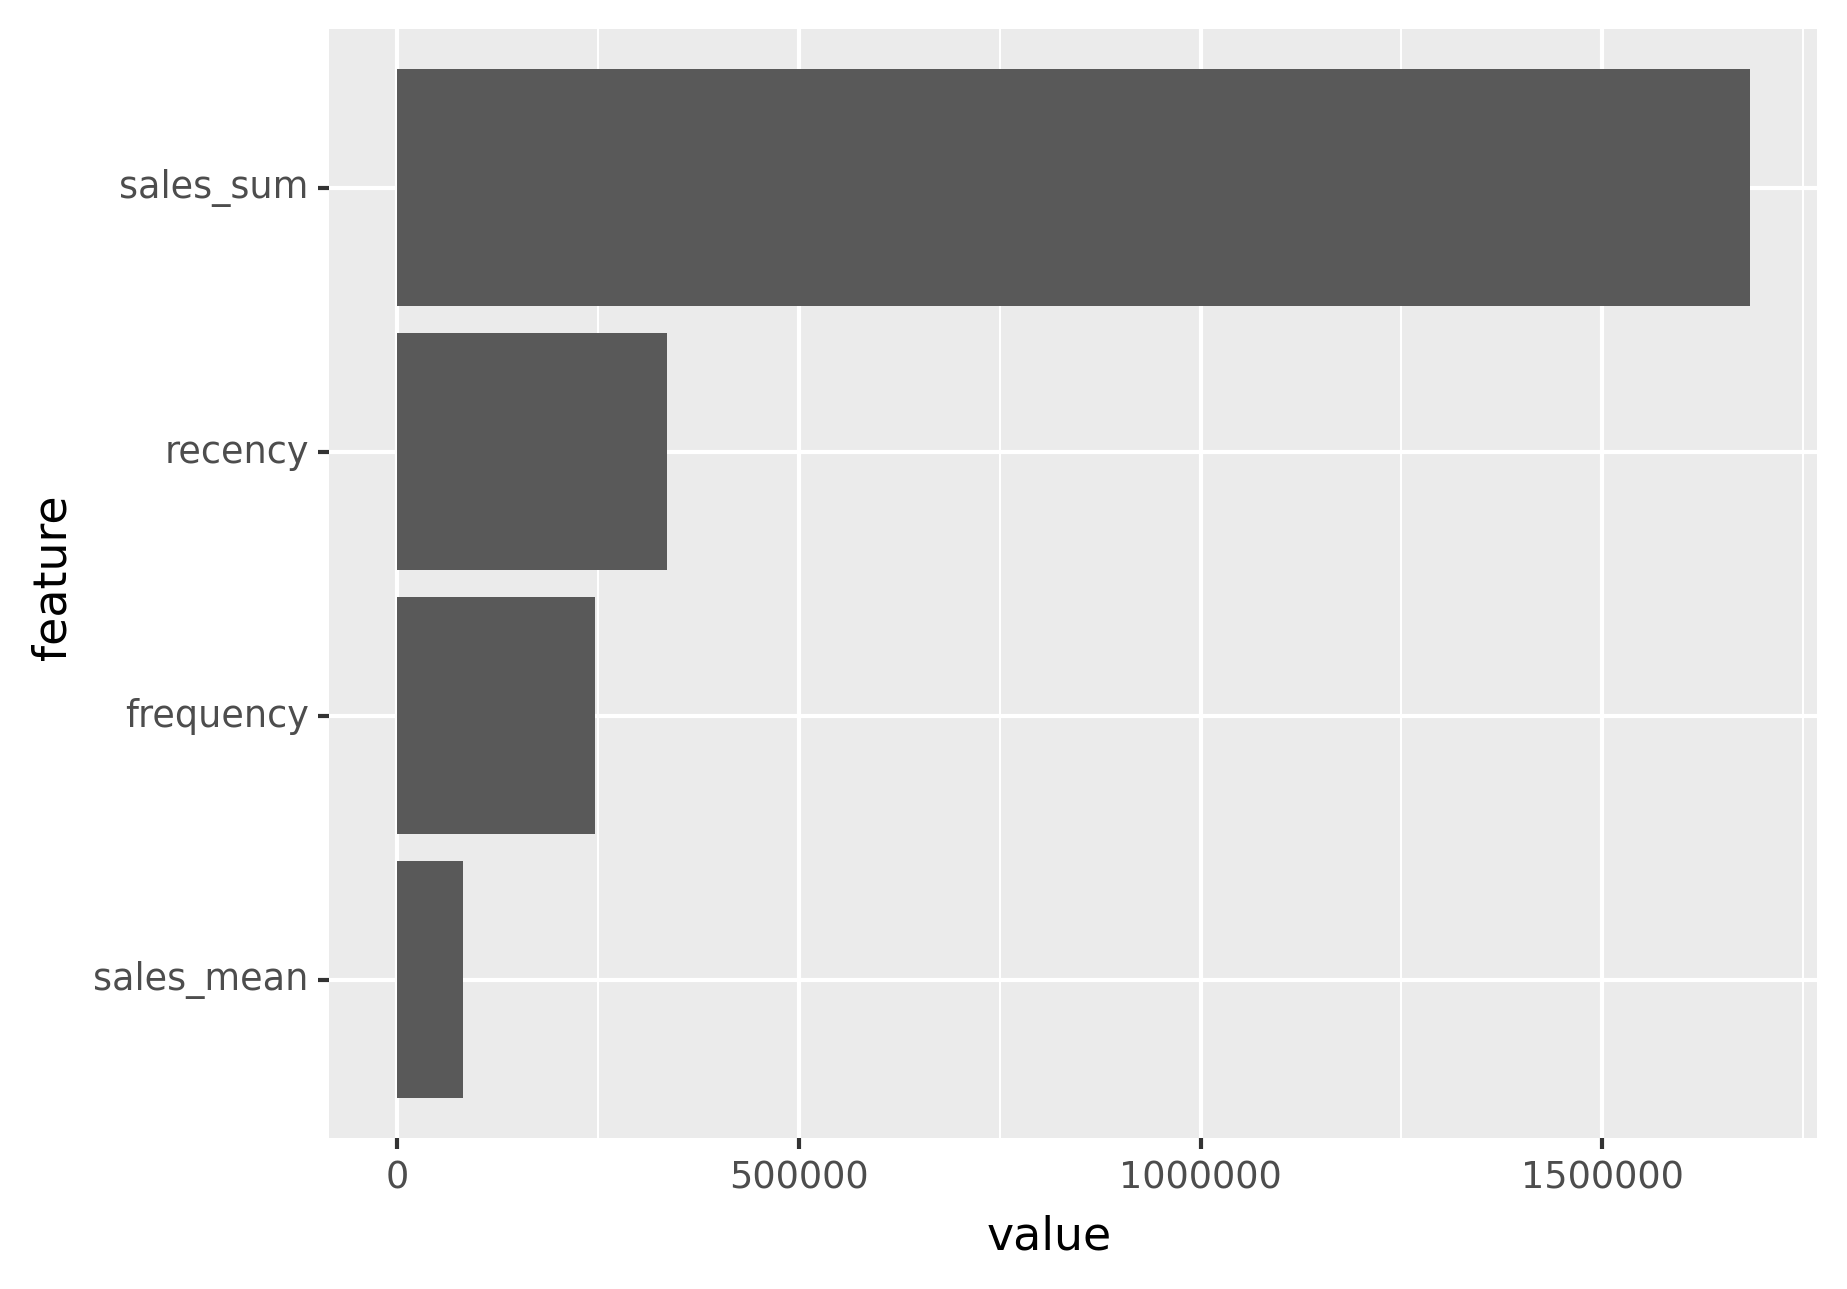

<ggplot: (8759973045481)>

In [130]:
pn.ggplot(
    pn.aes('feature','value'),
    data=imp_spend_amount_df
)\
  + pn.geom_col()\
  +pn.coord_flip()

What we can infer from above graph is that our feature is heavily dependent on sales_sum


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


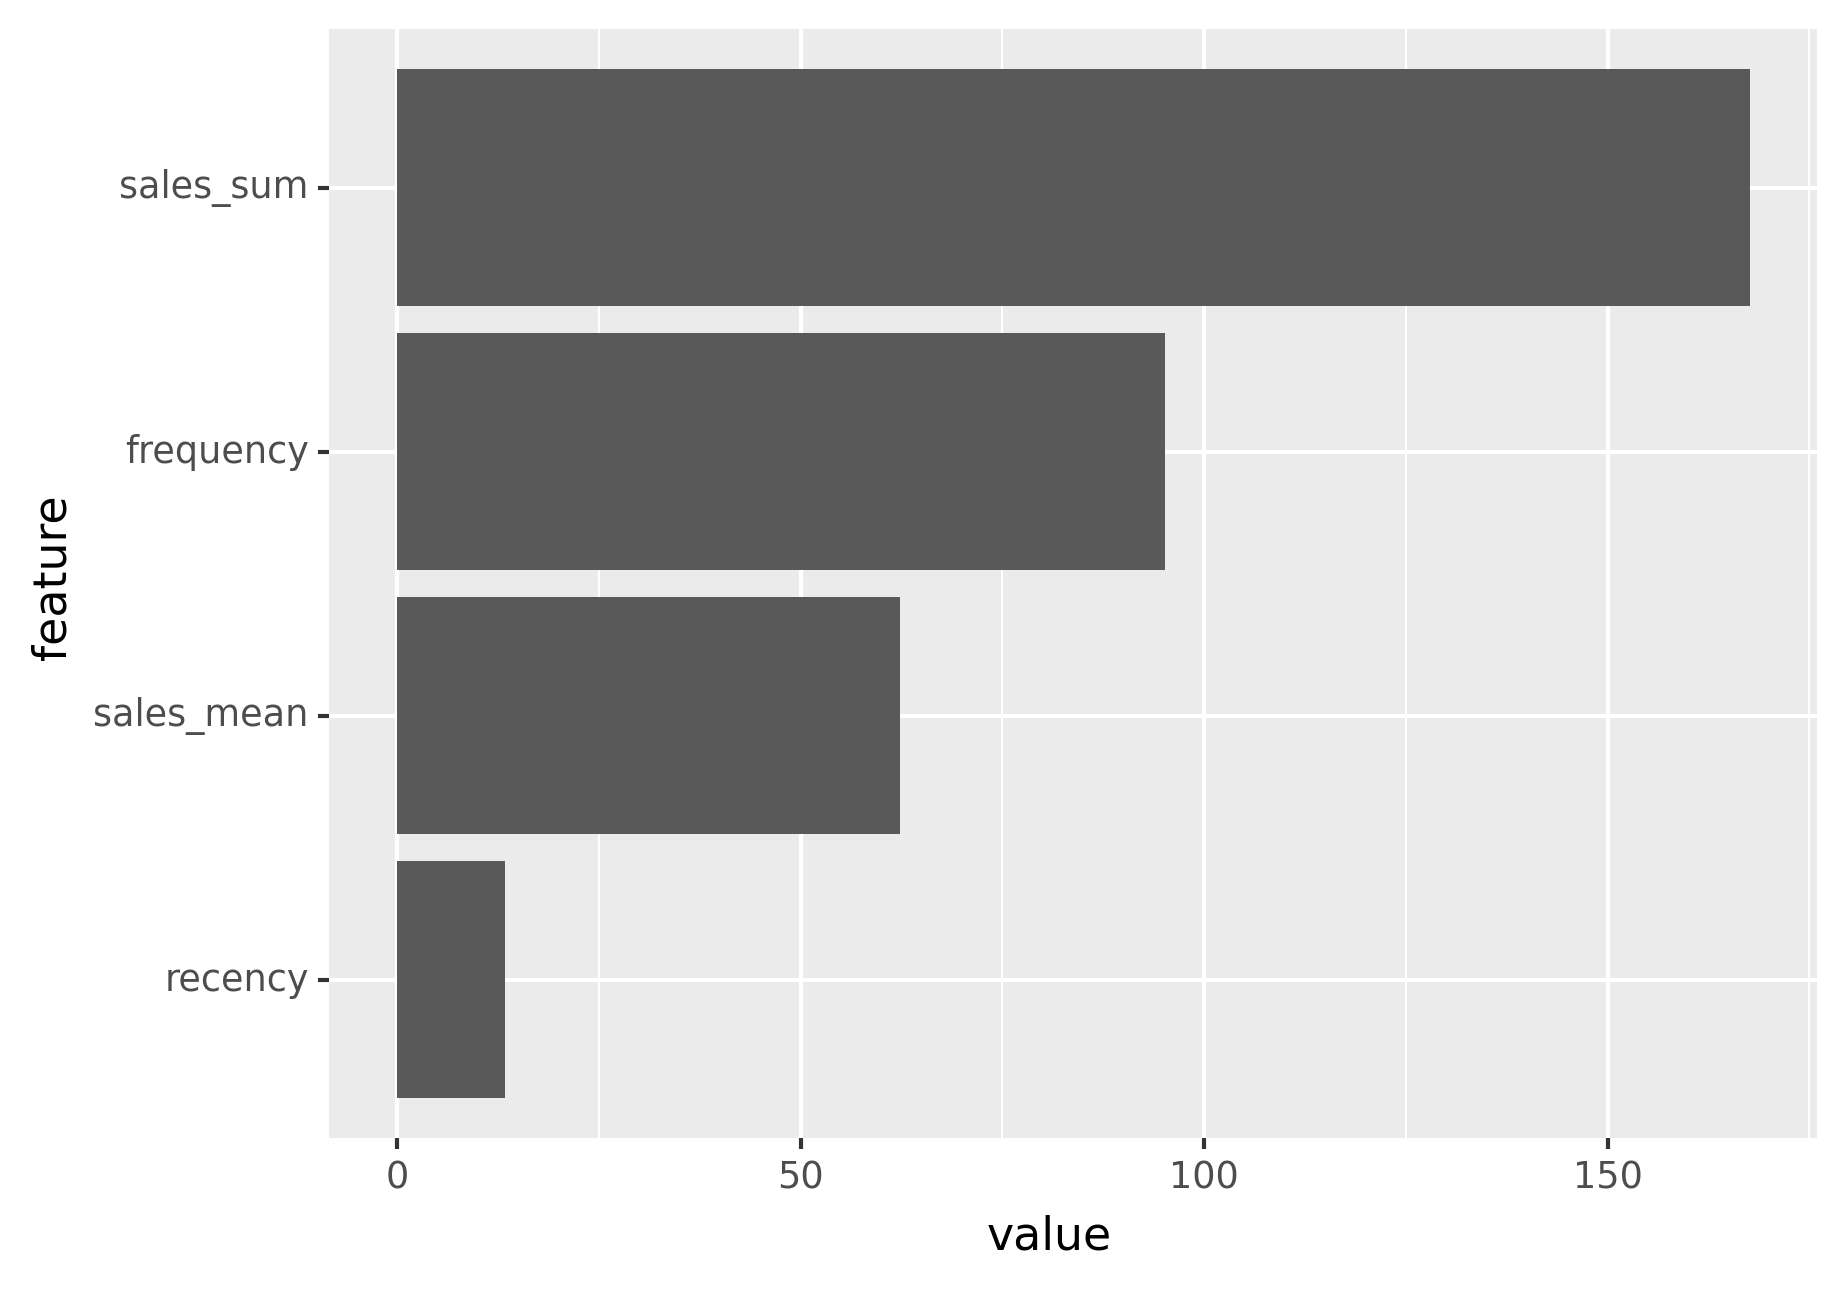

<ggplot: (8759972989705)>

In [131]:
#IMportance | spend Probability Model
imp_spend_amount_dict=xgb_clf_model\
  .best_estimator_\
  .get_booster()\
  .get_score(importance_type='gain')

imp_spend_amount_df=pd.DataFrame(
    data={
        'feature':list(imp_spend_amount_dict.keys()),
        'value':list(imp_spend_amount_dict.values())
    }
)\
  .assign(
      feature=lambda x:cat.cat_reorder(x['feature'],x['value'])
  )

pn.ggplot(
    pn.aes('feature','value'),
    data=imp_spend_amount_df
)\
  +pn.geom_col()\
  +pn.coord_flip()


SAVE WORK


In [132]:
#Save Predictions
predictions_df=pd.concat(
    [
        pd.DataFrame(predictions_reg).set_axis(['pred_spend'],axis=1),
        pd.DataFrame(predictions_clf)[[1]].set_axis(['pred_prob'], axis=1),
        features.reset_index()
    ],
    axis=1
)


In [133]:
predictions_df

,pred_spend,pred_prob,customer_id,recency,frequency,sales_sum,sales_mean,spend_90_total,spend_90_flag
0,18.977303,0.536339,3,-137.0,30,203.17,6.772333,0.00,0.0
1,5.002719,0.277831,5,-605.0,1,1.08,1.080000,0.00,0.0
2,12.996088,0.495822,6,-68.0,12,112.74,9.395000,0.00,0.0
3,13.321026,0.526898,8,-46.0,19,112.60,5.926316,146.54,1.0
4,11.065372,0.462235,9,-127.0,7,40.17,5.738571,49.41,1.0
...,...,...,...,...,...,...,...,...,...
8421,16.398312,0.525105,10275,-58.0,22,157.30,7.150000,0.00,0.0
8422,12.996088,0.468214,10277,-159.0,9,89.86,9.984444,140.48,1.0
8423,18.876333,0.533707,10278,-126.0,28,167.24,5.972857,0.00,0.0
8424,23.329084,0.590760,10280,-9.0,28,173.32,6.190000,59.45,1.0


From the above **table** we can see our target customers for instance customer with customer_id=3 has pred_spend approx 19 euros but hasn't spend any as we can see in (spend_90_total) 

Now using this information,

1- Which customers have the highest spend probability in the next 90-days?
target for new products similar to what theu have purchased in the past.

In [134]:
predictions_df\
  .sort_values('pred_prob', ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,sales_sum,sales_mean,spend_90_total,spend_90_flag
6402,140.370667,0.795201,7812,-10.0,106,671.44,6.334340,348.36,1.0
4038,120.355682,0.795201,4932,-7.0,102,647.87,6.351667,219.85,1.0
1306,148.056839,0.795201,1612,-11.0,114,910.11,7.983421,375.18,1.0
6861,126.773315,0.795201,8355,-11.0,96,725.98,7.562292,245.86,1.0
6313,136.260391,0.795201,7702,-7.0,182,1290.17,7.088846,226.61,1.0
...,...,...,...,...,...,...,...,...,...
3727,5.002719,0.277831,4546,-333.0,2,5.50,2.750000,0.00,0.0
7192,5.002719,0.277831,8762,-605.0,2,5.90,2.950000,0.00,0.0
3162,5.002719,0.277831,3861,-602.0,2,5.30,2.650000,0.00,0.0
3306,5.002719,0.277831,4031,-496.0,5,14.87,2.974000,0.00,0.0


2- Which customers have recently purchased but are unlikely to buy?
    - Incentivize actions to increase probability
    - provide discounts, encourage referring a friend, nuture by letting them know whats coming 

In [135]:
predictions_df\
  [
      predictions_df['recency'] > -90
  ]\
  [
      predictions_df['pred_prob'] < 0.30
  ]\
  .sort_values('pred_prob', ascending=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,pred_spend,pred_prob,customer_id,recency,frequency,sales_sum,sales_mean,spend_90_total,spend_90_flag
4511,5.002719,0.296872,5497,-88.0,9,25.36,2.817778,0.00,0.0
7162,5.327658,0.296872,8725,-8.0,9,24.78,2.753333,27.56,1.0
2034,5.327658,0.296872,2501,-28.0,10,25.90,2.590000,20.37,1.0
5599,5.327658,0.296872,6831,-46.0,12,25.74,2.145000,21.55,1.0
2882,5.327658,0.291982,3517,-42.0,8,23.26,2.907500,0.00,0.0
...,...,...,...,...,...,...,...,...,...
558,5.327658,0.285500,713,-18.0,1,2.70,2.700000,0.00,0.0
5206,5.327658,0.285500,6325,-50.0,1,2.59,2.590000,0.00,0.0
5303,5.327658,0.285500,6448,-44.0,2,5.27,2.635000,26.37,1.0
5337,5.327658,0.285500,6495,-22.0,5,10.82,2.164000,0.00,0.0


from the above table we can see customers that have purchased recently but they have probability of future spending low

3-Next up we have "Missed Oportunities" -big spenders that could be unlocked ---------
- Send bundle offers encouraging volume purchases
- Focus on missed opportunities


In [136]:
predictions_df\
  [
      predictions_df['spend_90_total']==0.0
  ]\
  .sort_values('pred_spend', ascending=False)

,pred_spend,pred_prob,customer_id,recency,frequency,sales_sum,sales_mean,spend_90_total,spend_90_flag
1784,136.260391,0.795201,2201,-3.0,186,1168.69,6.283280,0.0,0.0
5384,120.355682,0.795201,6560,-7.0,101,669.09,6.624653,0.0,0.0
362,106.812126,0.788925,467,-10.0,86,592.89,6.894070,0.0,0.0
3259,102.701843,0.788925,3976,-7.0,94,608.72,6.475745,0.0,0.0
6327,96.694534,0.788925,7720,-9.0,72,512.02,7.111389,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5194,5.002719,0.285500,6310,-191.0,4,9.41,2.352500,0.0,0.0
5193,5.002719,0.329344,6309,-376.0,12,38.02,3.168333,0.0,0.0
7694,5.002719,0.277831,9375,-411.0,2,6.09,3.045000,0.0,0.0
6021,5.002719,0.278761,7349,-382.0,4,13.77,3.442500,0.0,0.0


from the table we can see the customers having high spend probability but have spend nothing
